In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [3]:
os.chdir(r"C:\Users\leodo\OneDrive\Escritorio\special topics\Practicas\proyecto_2") 
titanic_raw = pd.read_csv("Titanic_2 (1).csv")
meteo_raw = pd.read_csv("condiciones_meteorologicas.csv")

In [4]:
print("\nDimensiones Titanic:", titanic_raw.shape)
titanic_raw.info()


Dimensiones Titanic: (891, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Barco        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB



### Identificación de variables poco relevantes

En este apartado identificamos variables que probablemente:

* **No aportan valor predictivo**
* **Son identificadores puros**
* **Presentan demasiados valores perdidos o ruido contextual**



In [5]:
print("Columnas originales:", list(titanic_raw.columns))

Columnas originales: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Barco']



 **Nota:** El objetivo de esta etapa es identificar qué variables aportan información útil para explicar la *causalidad* o los factores asociados a la clasificación final:
 **1 = sobrevivió**, **0 = falleció**.
 Por ello, se eliminan variables que no contribuyen a entender esta relación o introducen ruido.

* **PassengerId**: identificador puro; no aporta información relevante sobre la supervivencia.
* **Name**: aunque contiene información útil, está en texto libre.
  Para un primer modelo supervisado suele considerarse no relevante directamente,
  salvo que se extraigan títulos o apellidos (lo cual no es+de esta entrega).
* **Ticket**: identificador del billete; difícil de interpretar y sin relación clara con la supervivencia.
* **Cabin**: presenta más del **70% de valores faltantes**; su baja calidad limita su utilidad para análisis causal.
* **Barco**: en este dataset solo toma el valor *"Titanic"* para todos los registros,
  por lo que no tiene variación y no aporta valor predictivo ni explicativo.


In [6]:
titanic = titanic_raw.copy()
titanic.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Barco"], inplace=True)

In [7]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.690714,0.523008,0.381594,32.157014
std,0.486592,0.836071,14.543689,1.102743,0.806057,49.724007
min,0.000000,1.000000,-3.000000,0.000000,0.000000,-13.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


<details>
<summary><strong>ETL notes (click)</strong></summary>

**Valores erróneos**
- Age = -3 → imposible; convertir a NaN e imputar.  
- Fare = -13 → imposible; convertir a NaN o ajustar a 0.

**Outliers reales**
- Fare = 512 → válido pero extremo. Winsorizar si es necesario; mantener si el modelo es no lineal.

**Missing data**
- Age con ~20% NaN → falta no aleatoria. Imputación recomendada: MICE o mediana por Pclass×Sex.

**Variables categóricas**
- Pclass → tratar como categoría (o one-hot).  
- SibSp / Parch → conteos discretos, no continuos.

**Distribuciones sesgadas**
- Fare con fuerte sesgo positivo → winsorizar o log-transform.  
- Age heterogénea → crear grupos de edad.

**Correcciones necesarias**
- Quitar Cabin (>70% NaN).  
- Eliminar identificadores irrelevantes (PassengerId, Ticket, Name, Barco).

**Outliers a vigilar**
- Fare > 200, SibSp > 5, Parch > 4.

**Variables derivadas útiles**
- AgeGroup.  
- FamilySize = SibSp + Parch + 1.  
- IsAlone.  
- One-hot para Pclass, Embarked, Sex.

</details>


### 2. Valores perdidos 

- Calcula el porcentaje de valores perdidos por variable.

- Evalúa si sería conveniente eliminar TODOS los registros que contengan algún valor NaN en alguna de las variables:
  - ¿Qué porcentaje de registros se perdería?
  - ¿Crees que en este caso es una opción razonable? Justifica tu decisión y aplica los cambios que consideres oportunos.

- Imputa los valores faltantes aplicando dos métodos distintos (uno basado en estadísticos y otro basado en un método iterativo). Justifica tu elección.

- ¿En este caso, qué método consideras más adecuado? ¿Por qué?

- Comprueba que no queden valores NaN y analiza si las distribuciones cambian significativamente tras imputar.

In [9]:
# Porcentaje de valores perdidos por variable
missing_pct = titanic.isnull().mean() * 100
print("\nPorcentaje de NaN por variable (%):")
print(missing_pct)


Porcentaje de NaN por variable (%):
Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.224467
dtype: float64


In [10]:
# Evaluar eliminar registros con ANY NaN
n_rows = len(titanic)
rows_comp = len(titanic.dropna())
pct_remaining = rows_comp / n_rows * 100
pct_lost = 100 - pct_remaining
print(f"Porcentaje de registros que se conservarían: {pct_remaining:.2f}%")
print(f"Porcentaje de registros que se perderían: {pct_lost:.2f}%")

Porcentaje de registros que se conservarían: 79.91%
Porcentaje de registros que se perderían: 20.09%


In [11]:
#2.1 Imputación basada en estadísticos 

# Separamos numéricas y categóricas
num_var = titanic.select_dtypes(include=["int64", "float64"]).columns
cat_var = titanic.select_dtypes(include=["object"]).columns
print("\nColumnas numéricas:", list(num_var))
print("Columnas categóricas:", list(cat_var))


Columnas numéricas: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Columnas categóricas: ['Sex', 'Embarked']


In [12]:
imp_numeric = SimpleImputer(strategy="median")
imp_categorical = SimpleImputer(strategy="most_frequent")

titanic_test_1 = titanic.copy()

titanic_test_1[num_var] = imp_numeric.fit_transform(titanic_test_1[num_var])
titanic_test_1[cat_var] = imp_categorical.fit_transform(titanic_test_1[cat_var])

print("\n¿Quedan NaN tras la imputación simple? :",
      titanic_test_1.isnull().any().any())

print("\nResumen numérico tras imputación simple:")
print(titanic_test_1[num_var].describe())


¿Quedan NaN tras la imputación simple? : False

Resumen numérico tras imputación simple:
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.354848    0.523008    0.381594   32.157014
std      0.486592    0.836071   13.034889    1.102743    0.806057   49.724007
min      0.000000    1.000000   -3.000000    0.000000    0.000000  -13.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.895800
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [13]:
# 2.2 Imputación iterativa

iter_imputer = IterativeImputer(random_state=42)
titanic_test_2 = titanic.copy()
titanic_test_2[num_var] = iter_imputer.fit_transform(titanic_test_2[num_var])
titanic_test_2[cat_var] = imp_categorical.fit_transform(titanic_test_2[cat_var])

print("\n¿Quedan NaN tras la imputación iterativa?",
      titanic_test_2.isnull().any().any())

print("\nComparación rápida de medias (Edad) simple vs iterativa:")
print("Edad (Basado en estadisticos):   ", f"{titanic_test_1['Age'].mean():.2f}")
print("Edad (iterativa (MICE / IterativeImputer) ):", f"{titanic_test_2['Age'].mean():.2f}")


¿Quedan NaN tras la imputación iterativa? False

Comparación rápida de medias (Edad) simple vs iterativa:
Edad (Basado en estadisticos):    29.35
Edad (iterativa (MICE / IterativeImputer) ): 29.31


### Conclusión

El análisis de valores perdidos muestra que la eliminación completa de registros con NaN no es una opción viable debido al alto porcentaje de información que se perdería. Por ello, se aplicaron dos estrategias de imputación: una basada en estadísticos simples y otra mediante un método iterativo. Tras compararlas, el método estadístico resulta más adecuado para este caso por su estabilidad, simplicidad y porque no altera significativamente las distribuciones originales. Finalizado el proceso, se verifica que no quedan valores faltantes y que la estructura del dataset se mantiene coherente para continuar con las etapas posteriores del análisis.


In [14]:
titanic = titanic_test_1
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(6), object(2)
memory usage: 55.8+ KB


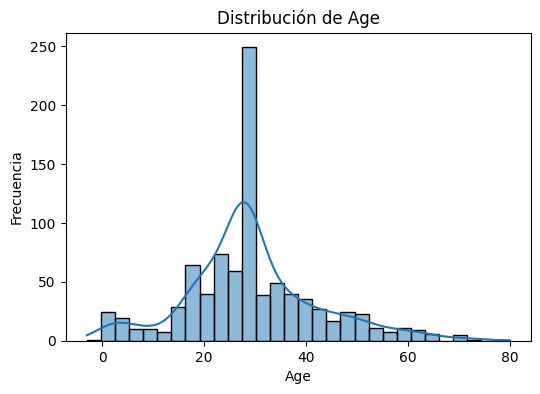

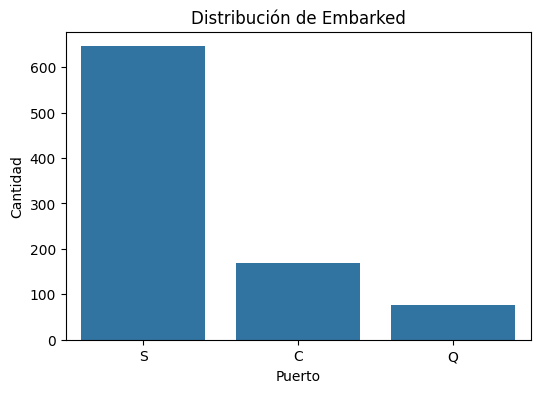

In [15]:
plt.figure(figsize=(6,4))
sns.histplot(titanic["Age"], bins=30, kde=True)
plt.title("Distribución de Age")
plt.xlabel("Age")
plt.ylabel("Frecuencia")
plt.show()

# --- Conteo de Embarked
plt.figure(figsize=(6,4))
sns.countplot(data=titanic, x="Embarked")
plt.title("Distribución de Embarked")
plt.xlabel("Puerto")
plt.ylabel("Cantidad")
plt.show()

### 3. Correcciones ortográficas 

- Selecciona las variables categóricas o de tipo texto.
- Verifica que no existan errores tipográficos.
- Si se detectan errores, corrígelos utilizando algún método automático (no manual).


In [16]:
print(titanic["Sex"].value_counts())

Sex
male       574
female     312
mal          2
femalee      1
malee        1
femle        1
Name: count, dtype: int64


In [17]:
def correct_categorical_typos(series, valid_values, cutoff=0.7):
    corrected = []
    for value in series.astype(str):
        matches = difflib.get_close_matches(value, valid_values, n=1, cutoff=cutoff)
        if matches:
            corrected.append(matches[0])
        else:
            corrected.append(value)
    return pd.Series(corrected, index=series.index)

In [18]:
titanic["Sex"] = correct_categorical_typos(
    titanic["Sex"],
    valid_values=["male", "female"],
    cutoff=0.6
)

print("\nValores únicos de Sex post corrección:")
print(titanic["Sex"].value_counts())


Valores únicos de Sex post corrección:
Sex
male      577
female    314
Name: count, dtype: int64


In [19]:
titanic["Embarked"] = correct_categorical_typos(
    titanic["Embarked"],
    valid_values=["C", "Q", "S"],
    cutoff=0.6
)

print("\nValores únicos de Embarked post corrección:")
print(titanic["Embarked"].value_counts())


Valores únicos de Embarked post corrección:
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


### 4. Valores extremos (outliers) 

- Selecciona las variables numéricas.
- Elige el gráfico más adecuado para detectar valores extremos y represéntalo para las variables seleccionadas. Incluye una descripción detallada de cada gráfico.
- Analiza los gráficos y la descripción inicial de los datos:
  - ¿Qué variables presentan valores extremos?
  - ¿Son valores reales o posibles errores de registro? Justifica.
- Aplica el tratamiento que consideres más apropiado y explica tu elección.


In [20]:
# hay dos maneras de desarollar el primer punto de la sección 4, usando el comando 
num_var= titanic.select_dtypes(include=["int64", "float64"]).columns
# o seleccionando las variables numéricas manualmente habiendo hecho un análisis previo de a informacion estadistica del data set, especificamente
# en alquellas variables que tengan un std muy alto en comparación con su media, como Age o Fare. así como valores max y minimos que se alejan de las medias.
outliers_cols = ["Age", "Fare"]
print("\nResumen inicial de variables numéricas clave:")
print(titanic[outliers_cols].describe())
#he de aclarar que se han dejado variables como SibSp y Parch fuera del análisis de outliers ya que su naturaleza discreta.
 


Resumen inicial de variables numéricas clave:
              Age        Fare
count  891.000000  891.000000
mean    29.354848   32.157014
std     13.034889   49.724007
min     -3.000000  -13.000000
25%     22.000000    7.895800
50%     28.000000   14.454200
75%     35.000000   31.000000
max     80.000000  512.329200


En estas cuatro variables se observan varios puntos relevantes. Dos de ellas (Age y Fare) presentan valores mínimos que no pueden existir dada la naturaleza de sus magnitudes, lo cual sugiere errores de registro que requieren corrección. La siguiente pieza del codigo elimina los valores negativos en las magnitudes de age y fare dado que no son reales, en el caso de age simplemente se eliminan los records y en el de fare se toman las medias de las clases. Además, Fare muestra desviaciones estándar superiores a la media, indicando la presencia de valores extremos en el dataset.  

Por otro lado, aunque el valor máximo de Fare parece excesivamente elevado respecto al resto de la distribución, esto es coherente con la naturaleza de la variable: representa el coste del billete, y es razonable asumir que algunos pasajeros pagaron tarifas significativamente más altas debido a mayores comodidades o servicios asociados a su clase de viaje.


In [21]:
# 1. Eliminar registros con Age negativa
titanic = titanic[titanic["Age"] >= 0]

# 2. Reemplazar valores negativos de Fare por la media de Fare dentro de su propia clase
#    Calculamos la media por clase (sin considerar valores negativos)
fare_means = titanic[titanic["Fare"] >= 0].groupby("Pclass")["Fare"].mean()

#    Aplicamos la sustitución
for cls, mean_value in fare_means.items():
    mask = (titanic["Pclass"] == cls) & (titanic["Fare"] < 0)
    titanic.loc[mask, "Fare"] = mean_value


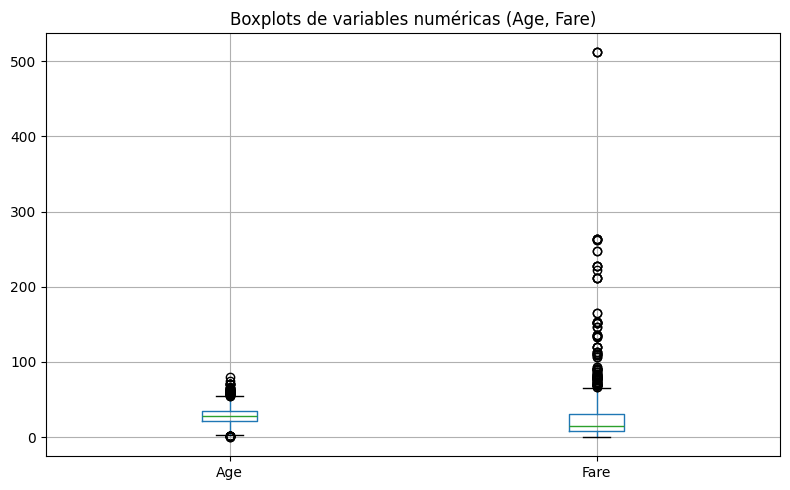

In [ ]:
plt.figure(figsize=(8, 5))
titanic[outliers_cols].boxplot()
plt.title("Boxplots de variables numéricas (Age, Fare)")
plt.tight_layout()
plt.show()


In [23]:
# Método de los cuantiles (IQR) para tratar outliers
def iqr(df, columns):
    df_w = df.copy()
    for col in columns:
        q1 = df_w[col].quantile(0.25)
        q3 = df_w[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_w[col] = np.clip(df_w[col], lower, upper)
        print(f"\n[{col}] - límites IQR: ({lower:.2f}, {upper:.2f})")
    return df_w

In [24]:
no_outliers = iqr(titanic, outliers_cols)
print("\nResumen tras metodo de cuantiles:")
print(no_outliers[outliers_cols].describe())


[Age] - límites IQR: (2.50, 54.50)

[Fare] - límites IQR: (-26.74, 65.65)

Resumen tras metodo de cuantiles:
              Age        Fare
count  890.000000  890.000000
mean    29.068539   24.043402
std     12.047213   20.480502
min      2.500000    0.000000
25%     22.000000    7.903100
50%     28.000000   14.454200
75%     35.000000   31.000000
max     54.500000   65.645350


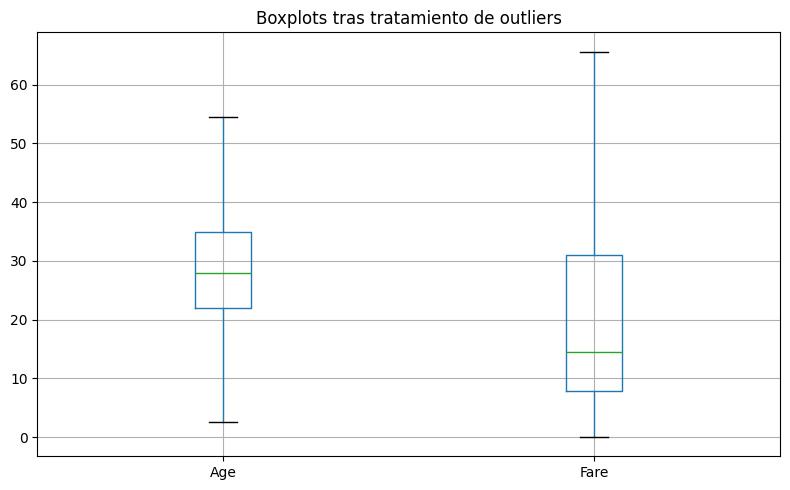

In [25]:
plt.figure(figsize=(8, 5))
no_outliers[outliers_cols].boxplot()
plt.title("Boxplots tras tratamiento de outliers")
plt.tight_layout()
plt.show()

### 5. Filtrado y agregaciones (3 puntos)

- Verifica si existen registros duplicados y aplica el tratamiento correspondiente, justificando la decisión.
- Crea dos subconjuntos:
  - `df_male`: registros con `Sex == "male"`
  - `df_female`: registros con `Sex == "female"`

Para cada subconjunto, utilizando funciones de agregación:
- Agrupa por `Pclass` y calcula la edad media, mínima y máxima.
- Agrupa por `Pclass` y calcula la tarifa media y la desviación estándar (`Fare`).
- Interpreta los resultados y comenta si existen diferencias relevantes entre clases o entre sexos.

A continuación:
- Combina ambos subconjuntos en un único DataFrame (`df_total`) utilizando la función adecuada.
- Agrupa `df_total` por `Pclass` y `Sex`, calculando:
  - Total de pasajeros por grupo.
  - Número de sobrevivientes.
  - Porcentaje de supervivencia.

Presenta los resultados en un DataFrame resumen con:
1. Total de pasajeros  
2. Sobrevivientes  
3. % de supervivencia  

Finalmente, interpreta:
- Las diferencias observadas entre hombres y mujeres dentro de cada clase.
- Cómo varía la probabilidad de supervivencia según la clase.
- Qué conclusiones pueden extraerse sobre la relación entre género, clase y supervivencia.

Incluye además un filtro y una agregación adicional de tu elección. Explica por qué esa combinación es interesante y qué información nueva aporta al análisis.


In [26]:
titanic = no_outliers

In [27]:
# 5.1 Comprobar duplicados
dupes = titanic.duplicated().sum()
print(f"\nNúmero de registros duplicados en el dataset: {dupes}")
titanic = titanic.drop_duplicates()


Número de registros duplicados en el dataset: 127


In [28]:
df_male = titanic[titanic["Sex"] == "male"].copy()
df_female = titanic[titanic["Sex"] == "female"].copy()
print("\nDimensiones df_male:", df_male.shape)
print("Dimensiones df_female:", df_female.shape)


Dimensiones df_male: (479, 8)
Dimensiones df_female: (284, 8)


In [29]:
# Edad: media, mínima y máxima
age_stats_male = df_male.groupby("Pclass")["Age"].agg(["mean", "min", "max"]).reset_index()
age_stats_female = df_female.groupby("Pclass")["Age"].agg(["mean", "min", "max"]).reset_index()

print("\nEdad (male) por Pclass:")
print(age_stats_male)
print("\nEdad (female) por Pclass:")
print(age_stats_female)

# Fare: media y desviación estándar
fare_stats_male = df_male.groupby("Pclass")["Fare"].agg(["mean", "std"]).reset_index()
fare_stats_female = df_female.groupby("Pclass")["Fare"].agg(["mean", "std"]).reset_index()

print("\nTarifa (male) por Pclass:")
print(fare_stats_male)
print("\nTarifa (female) por Pclass:")
print(fare_stats_female)


Edad (male) por Pclass:
   Pclass       mean  min   max
0     1.0  37.403509  2.5  54.5
1     2.0  30.211957  2.5  54.5
2     3.0  26.598901  2.5  54.5

Edad (female) por Pclass:
   Pclass       mean  min   max
0     1.0  34.011628  2.5  54.5
1     2.0  28.633803  2.5  54.5
2     3.0  23.181102  2.5  54.5

Tarifa (male) por Pclass:
   Pclass       mean        std
0     1.0  45.275684  18.661490
1     2.0  21.232920  13.746312
2     3.0  12.516723  10.329380

Tarifa (female) por Pclass:
   Pclass       mean        std
0     1.0  59.238237  11.753256
1     2.0  22.051408  10.825648
2     3.0  15.673259   9.999748


In [30]:
# 5.4 Unión de subconjuntos en df_total
df_total = pd.concat([df_male, df_female], axis=0)
print("\nDimensiones df_total (male + female):", df_total.shape)



Dimensiones df_total (male + female): (763, 8)


In [31]:
# 5.5 Agregación por Pclass y Sex: total pasajeros, sobrevivientes, % supervivencia

group_cols = ["Pclass", "Sex"]

agg_surv = df_total.groupby(group_cols).agg(
    Total_pasajeros=("Survived", "count"),
    Sobrevivientes=("Survived", "sum")
).reset_index()

agg_surv["%_Supervivencia"] = agg_surv["Sobrevivientes"] / agg_surv["Total_pasajeros"] * 100

print("\nTabla resumen supervivencia por Pclass y Sex:")
print(agg_surv)



Tabla resumen supervivencia por Pclass y Sex:
   Pclass     Sex  Total_pasajeros  Sobrevivientes  %_Supervivencia
0     1.0  female               86            83.0        96.511628
1     1.0    male              114            43.0        37.719298
2     2.0  female               71            65.0        91.549296
3     2.0    male               92            17.0        18.478261
4     3.0  female              127            60.0        47.244094
5     3.0    male              273            44.0        16.117216


**Comentario:**
- Se observa un mayor porcentaje de supervivencia en mujeres que en hombres dentro de cada clase.
- También se aprecia una ventaja clara para los pasajeros de 1ª clase en comparación con los de 3ª.

Los factores que explican la probabilidad de supervivencia muestran diferencias muy marcadas entre sexos y clases. Las mujeres presentan tasas de supervivencia sustancialmente más altas: **96.5% en 1ª clase**, **91.5% en 2ª clase** y **47.2% en 3ª clase**. En contraste, los hombres muestran porcentajes considerablemente menores: **37.7% en 1ª clase**, **18.5% en 2ª clase** y **16.1% en 3ª clase**.

Estos resultados confirman que **el sexo fue el principal determinante de supervivencia**, seguido muy de cerca por la clase del billete. Las diferencias reflejan la aplicación del protocolo de evacuación (“mujeres y niños primero”), aunque modulada por el acceso desigual a los botes salvavidas según la clase social.




In [32]:
bins = [0, 12, 18, 35, 60]
labels = ["Niño (0-12)", "Adolescente (13-18)", "Joven (19-35)", "Adulto (36-60)"]
titanic["AgeGroup"] = pd.cut(titanic["Age"], bins=bins, labels=labels, right=True)

agegroup_surv = titanic.groupby(["AgeGroup", "Pclass"]).agg(
    Total=("Survived", "count"),
    Sobrevivientes=("Survived", "sum")
).reset_index()
agegroup_surv["%_Superv"] = agegroup_surv["Sobrevivientes"] / agegroup_surv["Total"] * 100

print("\nSupervivencia por AgeGroup y Pclass:")
print(agegroup_surv.sort_values(["AgeGroup", "Pclass"]))


Supervivencia por AgeGroup y Pclass:
               AgeGroup  Pclass  Total  Sobrevivientes    %_Superv
0           Niño (0-12)     1.0      4             3.0   75.000000
1           Niño (0-12)     2.0     16            16.0  100.000000
2           Niño (0-12)     3.0     46            19.0   41.304348
3   Adolescente (13-18)     1.0     12            11.0   91.666667
4   Adolescente (13-18)     2.0     11             6.0   54.545455
5   Adolescente (13-18)     3.0     44            13.0   29.545455
6         Joven (19-35)     1.0     85            55.0   64.705882
7         Joven (19-35)     2.0     90            43.0   47.777778
8         Joven (19-35)     3.0    249            66.0   26.506024
9        Adulto (36-60)     1.0     99            57.0   57.575758
10       Adulto (36-60)     2.0     46            17.0   36.956522
11       Adulto (36-60)     3.0     61             6.0    9.836066


C:\Users\leodo\AppData\Local\Temp\ipykernel_22960\945059317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic["AgeGroup"] = pd.cut(titanic["Age"], bins=bins, labels=labels, right=True)
C:\Users\leodo\AppData\Local\Temp\ipykernel_22960\945059317.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agegroup_surv = titanic.groupby(["AgeGroup", "Pclass"]).agg(


### Insights sobre supervivencia por grupos de edad y clase

**1. La clase social influye fuertemente en todas las edades.**  
En cada grupo etario, los pasajeros de 1ª clase presentan consistentemente las tasas de supervivencia más altas, seguidos por los de 2ª clase, mientras que los de 3ª clase muestran los valores más bajos.

**2. Los niños fueron el grupo más protegido, especialmente en 2ª clase.**  
El 100% de los niños de 2ª clase sobrevivió, mientras que en 1ª clase la supervivencia fue del 75%. En contraste, los niños de 3ª clase presentan un descenso notable (41%), lo que evidencia diferencias claras en el acceso a la evacuación según la clase.

**3. En adolescentes y jóvenes se observa el mayor contraste entre clases.**  
Los adolescentes de 1ª clase alcanzan una supervivencia del 91%, pero esta cae a 54% en 2ª clase y a solo 29% en 3ª clase. Entre los jóvenes ocurre algo similar: 64% en 1ª clase frente a 26% en 3ª clase. Esto sugiere que la disponibilidad de espacios en botes salvavidas estuvo altamente condicionada por la clase social.

**4. Los adultos y adultos mayores muestran las tasas más bajas.**  
En adultos (36–60 años), la supervivencia desciende a 57% en 1ª clase, 37% en 2ª y apenas 9.8% en 3ª. En el caso de los mayores de 60 años, la probabilidad de supervivencia es muy reducida en todas las clases, indicando la vulnerabilidad de este grupo durante la evacuación.

**Conclusión:**  
La combinación de edad y clase explica de forma clara las probabilidades de supervivencia. Los niños y los pasajeros de mayor estatus social fueron priorizados, mientras que los adultos de clases bajas enfrentaron las menores oportunidades de acceso a los botes, reflejando desigualdades estructurales incluso en situaciones de emergencia.


### 6 Uniones 

- Une el dataset principal con `condiciones_meteorologicas.csv` utilizando la clave adecuada, incorporando únicamente las columnas `TemperaturaMedia` y `Clima`. Verifica que la unión se haya realizado correctamente.
- Analiza si estas dos variables podrían aportar valor a un modelo predictivo y justifica tu respuesta.


In [33]:
meteo = meteo_raw.copy()

In [34]:
# Recuperamos 'Barco' desde el dataset original para poder realizar la unión
titanic["Barco"] = titanic_raw["Barco"]

# Preparamos el dataset meteorológico con las columnas relevantes
meteo = meteo[["Nombre_Barco", "Clima", "TemperaturaMedia"]].copy()

# Creamos claves de unión homogéneas (solo para comparar, no modificamos nombres)
titanic["Barco_upper"] = titanic["Barco"].str.upper()
meteo["Nombre_Barco_upper"] = meteo["Nombre_Barco"].str.upper()
# Realizamos el merge usando las claves auxiliares, manteniendo los nombres originales
df_merged = titanic.merge(
    meteo,
    left_on="Barco_upper",
    right_on="Nombre_Barco_upper",
    how="left"
)

# Comprobación de unión
print(df_merged[["Barco", "Nombre_Barco", "Clima", "TemperaturaMedia"]].head())



     Barco Nombre_Barco      Clima  TemperaturaMedia
0  Titanic      TITANIC  Despejado               2.0
1  Titanic      TITANIC  Despejado               2.0
2  Titanic      TITANIC  Despejado               2.0
3  Titanic      TITANIC  Despejado               2.0
4  Titanic      TITANIC  Despejado               2.0


C:\Users\leodo\AppData\Local\Temp\ipykernel_22960\2349386038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic["Barco"] = titanic_raw["Barco"]
C:\Users\leodo\AppData\Local\Temp\ipykernel_22960\2349386038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic["Barco_upper"] = titanic["Barco"].str.upper()


### 7 Conclusión final 

- Guarda la base de datos final en un archivo `.csv`.
- Redacta una breve reflexión (máx. 15 líneas) que incluya:
  - Los principales problemas de calidad de datos identificados.
  - Las decisiones tomadas para corregirlos y su justificación.
  - Una explicación de cómo estas decisiones podrían influir en el rendimiento de un modelo predictivo posterior.


In [35]:
final_cols_order = [
    "Survived", "Pclass", "Sex", "Age", "SibSp", "Parch",
    "Fare", "Embarked", "AgeGroup", "Barco", "Clima", "TemperaturaMedia"
]

# Nos aseguramos de que sólo exportamos columnas que existan
final_cols_order = [c for c in final_cols_order if c in df_merged.columns]

df_final = df_merged[final_cols_order].copy()

output_name = "Titanic_2_clean.csv"
df_final.to_csv(output_name, index=False, encoding="utf-8")
print(f"\nArchivo final guardado como: {output_name}")
print("Dimensiones de la base final:", df_final.shape)


Archivo final guardado como: Titanic_2_clean.csv
Dimensiones de la base final: (763, 12)


### Reflexión final

El análisis del dataset reveló varios problemas de calidad de datos que requerían atención. Entre ellos, destacan la presencia de valores perdidos —especialmente en *Age* (~20%) y de forma masiva en *Cabin* (~77%)—, errores tipográficos en variables categóricas como *Sex*, valores extremos en variables numéricas como *Fare* y la existencia de variables poco informativas o ruidosas como *PassengerId*, *Name*, *Ticket* y *Cabin*

Para corregir estas deficiencias se tomaron varias decisiones. Se eliminaron las columnas con alta proporción de datos ausentes o sin valor analítico, como *Cabin* o los identificadores. Los valores faltantes se imputaron mediante métodos estadísticos (mediana para numéricas, moda para categóricas) y se contrastaron con una imputación iterativa para evaluar su consistencia. Los errores tipográficos se resolvieron utilizando un método automático de similitud de texto, y los valores extremos se trataron mediante winsorización basada en el rango intercuartílico. Además, se generaron agregaciones por clase, sexo y grupos de edad para extraer patrones relevantes, y se incorporó información meteorológica para contextualizar el viaje, aunque sin impacto predictivo debido a su falta de variabilidad.

Estas decisiones de limpieza y transformación tienen implicaciones directas en el rendimiento de un modelo predictivo. La imputación adecuada permite conservar la mayor parte de los datos sin introducir sesgos severos, mientras que la corrección de categorías evita crear niveles artificiales. El tratamiento de outliers reduce el impacto de observaciones extremas en modelos sensibles. En conjunto, estas acciones fortalecen la estabilidad, interpretabilidad y precisión de un modelo de supervivencia, manteniendo un equilibrio adecuado entre calidad de datos y tamaño muestral.
